In [24]:
import numpy as np
import pandas as pd
import cv2
import os
import pickle
import copy
import spectral as sp
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import NuSVC#
from sklearn.preprocessing import StandardScaler

### General Functions

In [25]:
# Function to display images in the notebook
def show_image(title, image, cmap=None):
    plt.figure(figsize=(4, 4))
    if len(image.shape) == 2:  # Grayscale images
        plt.imshow(image, cmap=cmap or 'gray')
    else:  # Color images
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [26]:
def visualize_predictions(df, image_shape, datacube, model_used="svm", show_image=True):
    """
    Visualizes predicted polymer labels over a selected hyperspectral band.

    Args:
        df: DataFrame containing predictions and coordinates.
        image_shape: Tuple (height, width) of the image.
        datacube: Hyperspectral datacube (height, width, bands).
        model_used: String indicating which model was used ('svm' or 'nn').
        show_image: Boolean to control whether to display the image.
    """
    # Select the 50th band from the datacube (change index if needed)
    selected_band = datacube[:, :, 50]
    
    # Normalize the selected band to the range [0, 255] for visualization
    selected_band = (selected_band - np.min(selected_band)) / (np.max(selected_band) - np.min(selected_band))
    selected_band = (selected_band * 255).astype(np.uint8)
    
    # Convert the selected band to a 3-channel image for overlay
    img = cv2.cvtColor(selected_band, cv2.COLOR_GRAY2BGR)  # Convert grayscale to 3-channel image
    
   # Map model_used to the correct DataFrame column
    if model_used == "pca_svm":
        label_column = "Predicted_Label_svm"
    elif model_used == "svm_only":
        label_column = "Predicted_Label_svm_only"
    elif model_used == "nn":
        label_column = "Predicted_Label_nn"
    else:
        raise ValueError(f"Unknown model_used: {model_used}")

    # Ensure the column exists in the DataFrame
    if label_column not in df.columns:
        print(f"Warning: Column '{label_column}' not found in DataFrame.")
        return

    # Check for missing labels
    missing_labels = df[df[label_column].isna()]
    if not missing_labels.empty:
        print("Warning: Some centroids are missing predicted labels:")
        print(missing_labels)

    height, width = image_shape  # Ensure centroids are within the valid range

    # Overlay the predicted labels
    for _, row in df.iterrows():
        if label_column in row and not pd.isna(row[label_column]):
            text = str(row[label_column])  # Convert label to string
            x, y = int(round(row['X_Coord'])), int(round(row['Y_Coord']))  # Ensure coordinates are integers

            # Ensure coordinates are within bounds
            if 0 <= x < width and 0 <= y < height:
                cv2.putText(img, text, (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
            else:
                print(f"Skipping out-of-bounds centroid: ({x}, {y})")
    
    # Show the final image with predicted labels overlaid
    if show_image:
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
        plt.title(f"Predicted Polymer Labels ({model_used.upper()}) on Selected Band")
        plt.axis("off")  # Hide axes for a cleaner look
        plt.show()


In [27]:
def load_hyperspectral_data(file_hdr_path):
    if not os.path.exists(file_hdr_path):
        print(f"Error: File {file_hdr_path} not found.")
        return None
    try:
        img = sp.open_image(file_hdr_path)
        return img.load()
    except Exception as e:
        print(f"Error loading hyperspectral data: {e}")
        return None

def perform_segmentation(datacube, filtersize=9, sigmaValues=30, clipLimit=2.0, tileSize=15,  
                          min_distance=2, threshold_value=30, alpha=0.7):
    selected_band = datacube[:, :, 50]  
    selected_band = (selected_band - np.min(selected_band)) / (np.max(selected_band) - np.min(selected_band))
    selected_band = (selected_band * 255).astype(np.uint8)
    blurred_image = cv2.bilateralFilter(selected_band, filtersize, sigmaValues, sigmaValues)
    clahe = cv2.createCLAHE(clipLimit, tileGridSize=(tileSize, tileSize))
    contrast_image = blurred_image
    # contrast_image = clahe.apply(blurred_image)
    _, binary_image = cv2.threshold(contrast_image, threshold_value, 255, cv2.THRESH_BINARY)
    distance = ndimage.distance_transform_edt(binary_image)
    indices = np.where(binary_image == 255)
    if len(indices[0]) > 0:
        reference_spectrum = np.mean(datacube[indices[0], indices[1], :], axis=0)
        spectral_distance = np.linalg.norm(datacube - reference_spectrum, axis=2)
        spectral_distance = (spectral_distance - np.min(spectral_distance)) / (np.max(spectral_distance) + 1e-8)
        weighted_distance = alpha * distance + (1 - alpha) * (1 - spectral_distance)
    else:
        weighted_distance = distance
    local_maxi = peak_local_max(weighted_distance, min_distance, labels=binary_image)
    local_maxi_mask = np.zeros_like(weighted_distance, dtype=bool)
    local_maxi_mask[tuple(local_maxi.T)] = True
    markers = ndimage.label(local_maxi_mask)[0]
    labels = watershed(-weighted_distance, markers, mask=binary_image)
    return labels



In the below processing, the filtering is modified from the training notebook since we cannot rely on a pre-set threshold based on the peaks of the class, since the class is not yet known.

In the inference notebook, since you don't know the material label in advance, you can't filter based on the label-specific average peak, like you do in the training notebook. Instead, you need to apply a global filter across all detected regions based on something like:

* the global average of all Max_Spectral values (as you were doing tentatively), or
* a percentile threshold, or
* simply keep all regions and let the classifier decide.

Since we are not training the background region as a separate class - the last option is not available. Can comment on this - it makes sense but how would the model change?

Instead of using solely the global average, statistical filtering based on spectral characteristics like variance, mean intensity, or peak amplitude is used to handle this.

In [28]:
def process_hyperspectral_file(filename, output_csv="processed_data.csv", show_image=True):
    if not os.path.exists(filename):
        print(f"File not found: {filename}")
        return [], None
    
    datacube = load_hyperspectral_data(filename)
    if datacube is None:
        return [], None

    labels = perform_segmentation(datacube)
    if np.max(labels) == 0:
        print(f"No regions found in {filename}")
        return [], labels
    
    # Select band for visualization
    selected_band = datacube[:, :, datacube.shape[2] // 2]
    selected_band = cv2.normalize(selected_band, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    color_image = cv2.cvtColor(selected_band, cv2.COLOR_GRAY2BGR)

    # Background spectrum
    background_mask = labels == 0
    background_coords = np.column_stack(np.where(background_mask))
    background_spectrum = np.mean(datacube[background_coords[:, 0], background_coords[:, 1], :], axis=0)
    
    raw_region_data = []
    rounded_coordinates = []

    for region_label in np.unique(labels):
        if region_label == 0:
            continue
        
        region_mask = labels == region_label
        region_coords = np.column_stack(np.where(region_mask))
        centroid = region_coords.mean(axis=0)
        x, y = round(centroid[1]), round(centroid[0])
        rounded_coordinates.append((x, y))

        region_spectrum = np.mean(datacube[region_coords[:, 0], region_coords[:, 1], :], axis=0)
        normalized_spectrum = np.clip(region_spectrum - background_spectrum, 0, None)
        max_spectral = np.max(normalized_spectrum)
        variance = np.var(normalized_spectrum)

        raw_region_data.append({
            "Filename": os.path.basename(filename),
            "Region": region_label,
            "X_Coord": x,
            "Y_Coord": y,
            "Original_Spectrum": region_spectrum.tolist(),
            "Normalized_Spectrum": normalized_spectrum.tolist(),
            "Max_Spectral": max_spectral,
            "Variance": variance
        })

    if not raw_region_data:
        print("No regions processed.")
        return [], labels

    # Compute global filtering thresholds
    max_vals = [entry["Max_Spectral"] for entry in raw_region_data]
    variances = [entry["Variance"] for entry in raw_region_data]
    avg_peak = np.mean(max_vals)
    std_peak = np.std(max_vals)
    avg_var = np.mean(variances)
    std_var = np.std(variances)

    peak_thresh = avg_peak - std_peak
    var_thresh = avg_var - std_var

    print(f"Peak threshold: {peak_thresh:.2f}, Variance threshold: {var_thresh:.4f}")

    # Apply filtering
    filtered_data = [
        entry for entry in raw_region_data
        if entry["Max_Spectral"] >= peak_thresh-150 and entry["Variance"] >= var_thresh-100
    ]

    if not filtered_data:
        print("All regions filtered out after thresholding.")
        return [], labels

    df_filtered = pd.DataFrame(filtered_data)
    spectral_df = pd.DataFrame(df_filtered["Original_Spectrum"].tolist(), columns=[f"Band_{i+1}" for i in range(len(df_filtered["Original_Spectrum"].iloc[0]))])
    df_filtered_final = pd.concat([df_filtered.drop(columns=["Original_Spectrum", "Normalized_Spectrum", "Variance"]), spectral_df], axis=1)

    # Draw centroids
    x_size = 5
    box_size = 10
    for cx, cy in rounded_coordinates:
        cv2.line(color_image, (cx - x_size, cy - x_size), (cx + x_size, cy + x_size), (0, 0, 255), 1)
        cv2.line(color_image, (cx - x_size, cy + x_size), (cx + x_size, cy - x_size), (0, 0, 255), 1)
        cv2.rectangle(color_image, (cx - box_size, cy - box_size), (cx + box_size, cy + box_size), (0, 255, 0), 1)

    if show_image:
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
        plt.title("Centroids and Bounding Boxes on Selected Band")
        plt.axis("off")
        plt.show()

    return df_filtered_final, labels

In [29]:
def apply_snv(spectrum):
    mean, std_dev = np.mean(spectrum), np.std(spectrum)
    return (spectrum - mean) / std_dev if std_dev != 0 else spectrum

## PCA - SVM Pipeline - Inference

In [30]:
# # Load PCA and SVM models
# model_filename = "pca_svm_model.pkl"
# with open("pca_svm_model.pkl", "rb") as file:
#         model_data = pickle.load(file)
#         scaler_pca = model_data["scaler"]
#         pca = model_data["pca"]
#         svm_pca = model_data["svm"]
#         label_encoder_pca = model_data["label_encoder"]

In [31]:
# Load PCA + SVM model
with open("pca_svm_model.pkl", "rb") as file:
    model_data = pickle.load(file)
    scaler_pca = model_data["scaler"]
    pca = model_data["pca"]
    svm_pca = model_data["svm"]
    label_encoder_pca = model_data["label_encoder"]

# Load SVM-only model
with open("svm_model.pkl", "rb") as file:
    model_data_svm = pickle.load(file)
    scaler_svm = model_data_svm["scaler"]  # Only scaler, no PCA
    svm_only = model_data_svm["svm"]
    label_encoder_svm = model_data_svm["label_encoder"]


In [32]:
# def classify_regions(df):
#     band_keys = [f"Band_{i+1}" for i in range(204)]
#     for i in range(len(df)):
#         spectrum_values = np.array(df.loc[i, band_keys])  # Extract spectrum as array
#         snv_values = apply_snv(spectrum_values)  # Apply SNV to full spectrum
#         df.loc[i, band_keys] = snv_values  # Store transformed spectrum
#     X_scaled = scaler.transform(df[band_keys])
#     X_pca = pca.transform(X_scaled)
#     predictions = svm.predict(X_pca)
#     df['Predicted_Label_svm'] = label_encoder.inverse_transform(predictions)
#     return df

In [33]:
def classify_regions(df, model_type="pca_svm"):
    band_keys = [f"Band_{i+1}" for i in range(204)]
    
    # Apply SNV to all spectra
    for i in range(len(df)):
        spectrum_values = np.array(df.loc[i, band_keys])
        snv_values = apply_snv(spectrum_values)
        df.loc[i, band_keys] = snv_values

    if model_type == "pca_svm":
        X_scaled = scaler_pca.transform(df[band_keys])
        X_pca = pca.transform(X_scaled)
        predictions = svm_pca.predict(X_pca)
        df['Predicted_Label_svm'] = label_encoder_pca.inverse_transform(predictions)
    elif model_type == "svm_only":
        X_scaled = scaler_svm.transform(df[band_keys])
        predictions = svm_only.predict(X_scaled)
        df['Predicted_Label_svm_only'] = label_encoder_svm.inverse_transform(predictions)
    else:
        raise ValueError(f"Unknown model_type: {model_type}")

    return df


In [34]:
# Load the PCA-transformed training data (if saved)
training_pca_csv = "training_pca_data.csv"
training_labels_csv = "training_labels.csv"

# Load the training PCA data and labels
training_pca_data = np.loadtxt(training_pca_csv, delimiter=",")
training_labels = np.loadtxt(training_labels_csv, delimiter=",", dtype=str)

# Compute mean and std from the training dataset
training_mean = np.mean(training_pca_data, axis=0)
training_std = np.std(training_pca_data, axis=0)

In [35]:
def plot_pca_projection(df, pca, training_pca_data, training_labels):
    """
    Plots new data points on the existing PCA projection.
    
    Parameters:
    - df: Processed DataFrame with spectral data
    - pca: Trained PCA model
    - training_pca_data: PCA-transformed training data
    - training_labels: String labels of the training data
    """

    band_keys = [f"Band_{i+1}" for i in range(204)]
    for i in range(len(df)):
        spectrum_values = np.array(df.loc[i, band_keys])  # Extract spectrum as array
        snv_values = apply_snv(spectrum_values)  # Apply SNV to full spectrum
        df.loc[i, band_keys] = snv_values  # Store transformed spectrum
    X_scaled = scaler.transform(df[band_keys])
    new_pca_points = pca.transform(X_scaled)
    
    # Plot training data
    plt.figure(figsize=(8, 6))
    
    unique_labels = np.unique(training_labels)
    for label in unique_labels:
        indices = np.where(training_labels == label)[0]  # Find indices where label matches
        plt.scatter(training_pca_data[indices, 0], training_pca_data[indices, 1], 
                    label=label, alpha=0.5)

    # Plot new data points
    plt.scatter(new_pca_points[:, 0], new_pca_points[:, 1], c='red', marker='x', s=100, label="New Data")

    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("New Data Projection onto PCA Space")
    plt.legend()
    plt.grid(True)
    plt.show()



# FILE SELECTOR

* 25 --> PP + ABS
* 26 --> ABS + HDPE
* 27 --> HDPE + PET
* 28 --> HDPE + PP
* 30 --> ABS + PP


* 21/22 --> Used MPs 1
* 23/24 --> Used MPs 2

In [36]:
# filename = "G:/My Drive/1. Educ/1. Masters/Thesis/Work Folder/data/2025-01-23_030/capture/2025-01-23_030.hdr"
# df_filtered_final, labels = process_hyperspectral_file(filename)
# df_classified = classify_regions(df_filtered_final)
# datacube = load_hyperspectral_data(filename)
# visualize_predictions(df_classified, (512, 512), datacube, model_used="svm")

Peak threshold: 788.81, Variance threshold: 24528.8594


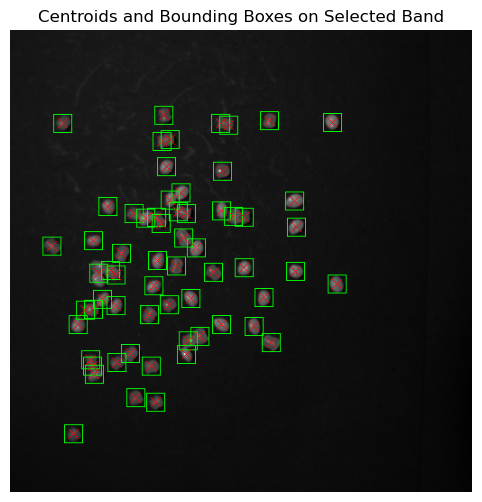

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


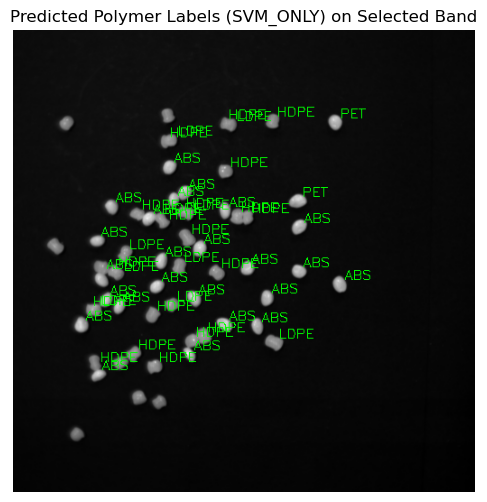

In [46]:
filename = "data/2025-01-23_026/capture/2025-01-23_026.hdr"
df_filtered_final, labels = process_hyperspectral_file(filename)
df_classified = classify_regions(df_filtered_final, model_type="pca_svm")
df_svm_only = classify_regions(df_filtered_final, model_type="svm_only")
datacube = load_hyperspectral_data(filename)
visualize_predictions(df_classified, (512, 512), datacube, model_used="svm_only")

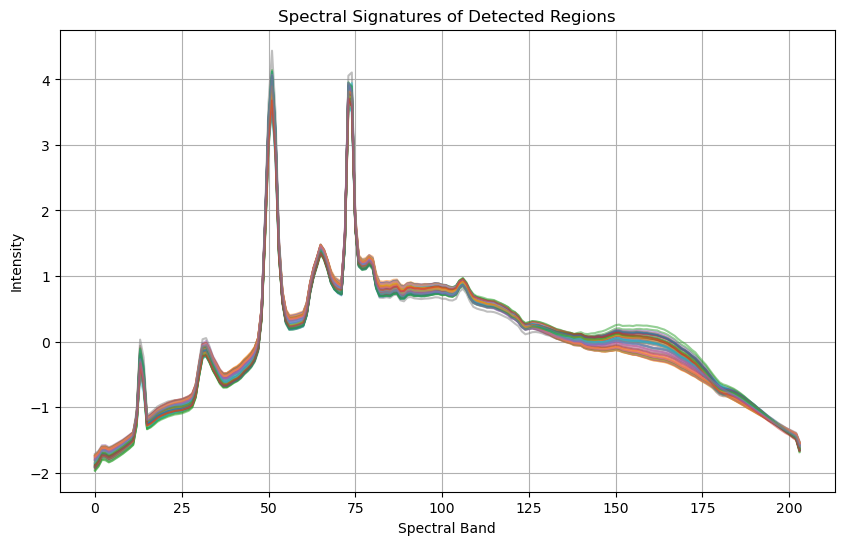

In [47]:
# Extract spectral data
band_columns = [col for col in df_filtered_final.columns if col.startswith("Band_")]
spectra = df_filtered_final[band_columns].values.T  # Transpose for plotting

# Plot all spectra
plt.figure(figsize=(10, 6))
for spectrum in spectra.T:  # Iterate over rows (each spectrum)
    plt.plot(spectrum, alpha=0.5)  # Adjust alpha for visibility

plt.xlabel("Spectral Band")
plt.ylabel("Intensity")
plt.title("Spectral Signatures of Detected Regions")
plt.grid()
plt.show()


Need to save PCA Data from training to import here and project to understand how PCA is working here.

In [48]:
plot_pca_projection(df_filtered_final, pca, training_pca_data, training_labels)


NameError: name 'scaler' is not defined

## Neural Network - MLP - Inference

### First Model

In [40]:
import torch
import torch.nn as nn

class MLPClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # First hidden layer
        self.dropout1 = nn.Dropout(0.3)  # 30% dropout
        self.fc2 = nn.Linear(128, 64)  # Second hidden layer
        self.dropout2 = nn.Dropout(0.3)  # 30% dropout
        self.fc3 = nn.Linear(64, num_classes)  # Output layer
        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout after first layer
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)  # Apply dropout after first layer
        x = self.fc3(x)  # No activation in last layer (CrossEntropyLoss includes softmax)
        return x


# Set parameters based on training setup
input_size = 204  # Number of spectral bands (adjust as needed)
hidden_size = 128  # Must match training setup
num_classes = 7  # Number of polymer classes (adjust as needed)

# Initialize the model
model = MLPClassifier(input_size, num_classes)

# Load the saved state_dict
model.load_state_dict(torch.load("best_mlp_model.pth"))

# Set model to evaluation mode (important for inference)
model.eval()


C:\Users\chris\AppData\Local\Temp\ipykernel_26540\3314355553.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_mlp_model.pth"))


MLPClassifier(
  (fc1): Linear(in_features=204, out_features=128, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=7, bias=True)
  (relu): ReLU()
)

In [41]:
import torch.nn.functional as F

def predict_spectra(model, spectra):
    """
    Predicts the polymer class for multiple spectral samples.

    Args:
        model: Trained MLP model.
        spectra: A 2D NumPy array or tensor where each row is a spectrum.

    Returns:
        List of predicted polymer class labels and their probabilities.
    """
    model.eval()  # Set model to evaluation mode

    # Convert input data to PyTorch tensor
    spectra_tensor = torch.tensor(spectra, dtype=torch.float32)

    # Perform inference
    with torch.no_grad():
        outputs = model(spectra_tensor)  # Raw logits
        probabilities = F.softmax(outputs, dim=1)  # Convert logits to probabilities
        predicted_indices = torch.argmax(probabilities, dim=1)  # Get index of max probability

    # Convert predictions to class labels
    predicted_labels = label_encoder.inverse_transform(predicted_indices.numpy())

    return predicted_labels, probabilities.numpy()  # Return both predictions & probabilities


In [42]:
def preprocess_and_predict(df, model, scaler, apply_snv):
    """
    Applies preprocessing (SNV and scaling) and predicts polymer classes using the trained model.

    Args:
        df: DataFrame containing spectral data.
        model: Trained PyTorch model.
        scaler: Fitted Scaler object (e.g., StandardScaler) used during training.
        apply_snv: Function to apply Standard Normal Variate (SNV) transformation.

    Returns:
        DataFrame with predicted polymer class labels.
    """
    # Extract spectral features (assumes bands are named "Band_1", "Band_2", ..., "Band_N")
    band_keys = [f"Band_{i+1}" for i in range(input_size)]
    
    # Apply SNV transformation to each spectrum
    for i in range(len(df)):
        spectrum_values = np.array(df.loc[i, band_keys])  # Extract spectrum as array
        snv_values = apply_snv(spectrum_values)  # Apply SNV
        df.loc[i, band_keys] = snv_values  # Store transformed spectrum
    
    # Apply the same scaling used in training
    spectra_matrix = df[band_keys].values
    spectra_scaled = scaler.transform(spectra_matrix)  # Ensure scaler is fitted during training

    # Predict polymer classes
    predicted_labels, probabilities = predict_spectra(model, spectra_scaled)

    # Store predictions in DataFrame
    df["Predicted_Label_nn"] = predicted_labels

    return df


In [ ]:
df_classified = preprocess_and_predict(df_classified, model, scaler, apply_snv)
visualize_predictions(df_classified, (512, 512), datacube, model_used="nn")

NameError: name 'scaler' is not defined

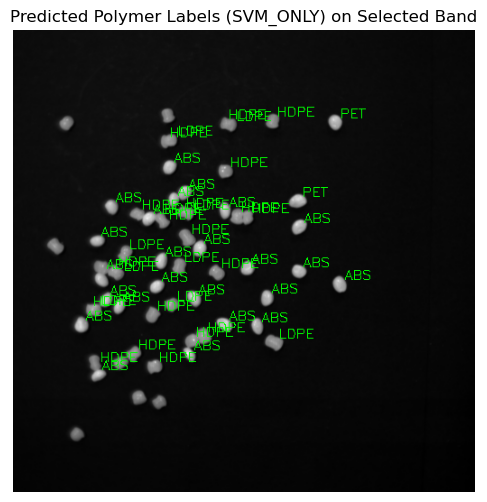

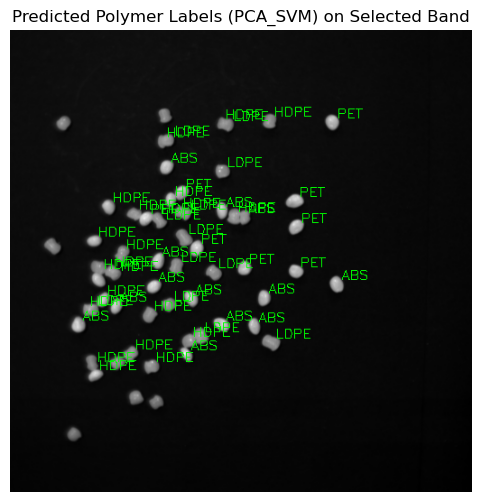

In [44]:
visualize_predictions(df_classified, (512, 512), datacube, model_used="svm_only")
visualize_predictions(df_classified, (512, 512), datacube, model_used="nn")
visualize_predictions(df_classified, (512, 512), datacube, model_used="pca_svm")

In [ ]:
# Calculate percentages for SVM
polymer_counts_svm = df_classified['Predicted_Label_svm'].value_counts(normalize=True) * 100
polymer_percentages_svm = polymer_counts_svm.to_dict()

# Calculate percentages for Neural Network
polymer_counts_nn = df_classified['Predicted_Label_nn'].value_counts(normalize=True) * 100
polymer_percentages_nn = polymer_counts_nn.to_dict()

# Combine results into a DataFrame
all_polymers = set(polymer_percentages_svm.keys()).union(polymer_percentages_nn.keys())
comparison_data = {
    "Polymer": [],
    "SVM (%)": [],
    "Neural Network (%)": []
}

for polymer in sorted(all_polymers):
    comparison_data["Polymer"].append(polymer)
    comparison_data["SVM (%)"].append(polymer_percentages_svm.get(polymer, 0.0))
    comparison_data["Neural Network (%)"].append(polymer_percentages_nn.get(polymer, 0.0))

comparison_df = pd.DataFrame(comparison_data)

# Print as table
print(comparison_df.to_string(index=False))


KeyError: 'Predicted_Label_nn'

Notes:

* SVM is requiring more processing since we need to convert to PCA before training, otherwise the SVM will overfit since it will create a supporting vector with each feature due to a large number of features, which are not really features.
* NN is working on the whole dataset as is. PCA may fiscard useful information that can hurt the classification problem. PCA focuses on variance, but other spectral relationships to distinguish polymers may exist - which are learnt by the NN. 
* Unlike SVM - that struggle with high-dimensional data, deep learning architectures learn herarchical features from raw data.
* dropout and batch normalisation is used to prevent overfitting


Our dataset is quite clean, in the sense that even the micropastics used are virgin polymers. If dataset is noisy, PCA may be used to act as a denoiser.

Question:

* How would different colours affect the model? Future work - add more colours to the neural network to train.

## Best Model - Optuna Test

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 114)  # One hidden layer with 114 neurons
        self.dropout = nn.Dropout(0.2324)      # 23.24% dropout
        self.activation = nn.LeakyReLU(0.01)   # LeakyReLU activation
        self.output = nn.Linear(114, num_classes)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.output(x)  # No activation here (CrossEntropyLoss includes softmax)
        return x

# --- Set parameters based on training setup ---
input_size = 204  # Number of features in your spectral data
num_classes = 7   # Number of polymer classes (update if needed)

# Initialize the model with exact same structure
# model = MLPClassifier(input_size, num_classes)
model = nn.Sequential(
    nn.Linear(204, 114),
    nn.LeakyReLU(0.01),
    nn.Dropout(0.2324),
    nn.Linear(114, 7)
)

# Load trained weights
model.load_state_dict(torch.load("best_optuna_model.pth"))

# Set to eval mode for inference
model.eval()


C:\Users\chris\AppData\Local\Temp\ipykernel_26540\3520693542.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_optuna_model.pth"))


Sequential(
  (0): Linear(in_features=204, out_features=114, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Dropout(p=0.2324, inplace=False)
  (3): Linear(in_features=114, out_features=7, bias=True)
)

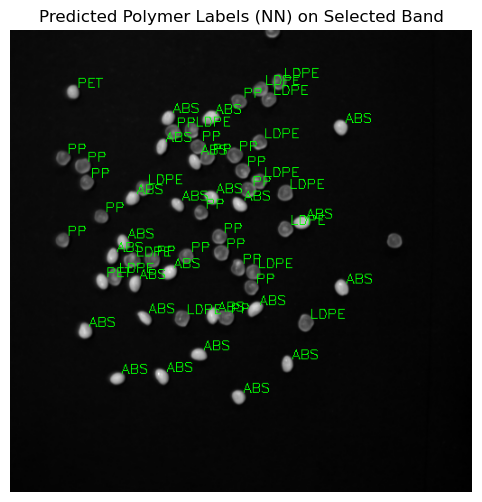

In [ ]:
df_classified = preprocess_and_predict(df_classified, model, scaler, apply_snv)
visualize_predictions(df_classified, (512, 512), datacube, model_used="nn")